In [246]:
from sys import exit
import matplotlib.pyplot as plt
import pandas as pd
import corner
from numpy import sin, cos, sqrt
import numpy as np
from helpers import *
from sys import argv
from matplotlib.ticker import ScalarFormatter

PLOT_DIR = f"plots/aa18_plots_referee"
plt.style.use('palmerio')
BINS = 70

# Constants
g0 = 100.
GWH_O2 = 135.6
GWH_O3 = 226.
GWH_DESIGN = 429.4
GWH_MAX = 500.0
AH_O2 = GWH_O2 / 1.58
AH_O3 = GWH_O3 / 1.58
AH_DESIGN = GWH_DESIGN / 1.58
AH_MAX = GWH_MAX / 1.58
GWH_MIN = 50.
LS_MIN = -1.0
LS_MAX = 1.5
vlas = 15.
ska1s = 3.
ska2s = 0.3
fnx_fnr = 1.80e-5
fx_fnr = 4.23e-19
thin=0.4
thick=0.7

# Fractions as function of horizon
gwh_l = np.linspace(GWH_MIN, GWH_MAX, 30)
sens_l = np.linspace(LS_MIN, LS_MAX, 20)
X, Y = np.meshgrid(gwh_l, sens_l)
mean_tv = np.zeros_like(X)
std_tv = np.zeros_like(X)
frac = np.zeros_like(X)
frac_vla = np.zeros_like(gwh_l)
frac_ska1 = np.zeros_like(gwh_l)
frac_ska2 = np.zeros_like(gwh_l)
num_vla = np.zeros_like(gwh_l)
num_ska1 = np.zeros_like(gwh_l)
num_ska2 = np.zeros_like(gwh_l)
mean_lpf = np.zeros_like(X)
n_joint = np.zeros_like(X)
frac_onaxis = np.zeros_like(X)
e0l = 10 ** np.array([50., 50.5, 51., 51.5, 52.])
e0ls = ['500', '505', '510', '515', '520']
g16f150 = dict()
g16f150ne=dict()
g16ang = dict()
g16frac = dict()


# Read event data and create pandas data frame.
print(f"Collecting data from 'data/g16_f_design.data'")
dfd = pd.read_csv("data/g16_f_design.data", sep=" ",
        names=['d', 'n', 'e0', 'eb',
        'tv', 'tj', 'pte', 'ptne', 'pf', 'pm'],
        dtype={'ti': float, 'd': float, 'n': float, 'e0': float,
        'eb': float, 'tv': float, 'tj': float, 'pte': float, 'ptne': float,
        'pf': float, 'pm': float})
dfd = dfd.loc[dfd['eb'] < 0.8]
# Add other columns to frame
dfd['lpte'] = log(dfd['pte'])
dfd['lptne'] = log(dfd['ptne'])
dfd['ln'] = log(dfd['n'])
dfd['lpf'] = log(dfd['pf'])
dfd['le0'] = log(dfd['e0'])
dfd['ld'] = log(dfd['d'])

print(f"Collecting data from 'data/g16_f_O2.data'")
dfO2 = pd.read_csv("data/g16_f_O2.data", sep=" ",
        names=['d', 'n', 'e0', 'eb',
        'tv', 'tj', 'pte', 'ptne', 'pf', 'pm'],
        dtype={'ti': float, 'd': float, 'n': float, 'e0': float,
        'eb': float, 'tv': float, 'tj': float, 'pte': float, 'ptne': float,
        'pf': float, 'pm': float})
dfO2 = dfO2.loc[dfO2['eb'] < 0.8]
# Add other columns to frame
dfO2['lpte'] = log(dfO2['pte'])
dfO2['lptne'] = log(dfO2['ptne'])
dfO2['ln'] = log(dfO2['n'])
dfO2['lpf'] = log(dfO2['pf'])
dfO2['le0'] = log(dfO2['e0'])
dfO2['ld'] = log(dfO2['d'])

print(f"Collecting data from 'data/g16_f_O3.data'")
dfO3 = pd.read_csv("data/g16_f_O3.data", sep=" ",
        names=['d', 'n', 'e0', 'eb',
        'tv', 'tj', 'pte', 'ptne', 'pf', 'pm'],
        dtype={'ti': float, 'd': float, 'n': float, 'e0': float,
        'eb': float, 'tv': float, 'tj': float, 'pte': float, 'ptne': float,
        'pf': float, 'pm': float})
dfO3 = dfO3.loc[dfO3['eb'] < 0.8]
# Add other columns to frame
dfO3['lpte'] = log(dfO3['pte'])
dfO3['lptne'] = log(dfO3['ptne'])
dfO3['ln'] = log(dfO3['n'])
dfO3['lpf'] = log(dfO3['pf'])
dfO3['le0'] = log(dfO3['e0'])
dfO3['ld'] = log(dfO3['d'])

# Collect event data according to detections in GW, AG, etc.
print("Creating derived dataframes.")
gw_O2 = dfO2.loc[1. + 6. * cos(dfO2['tv']) ** 2 + cos(dfO2['tv']) ** 4\
            > 8 * dfO2['d'] ** 2 / AH_O2 ** 2]
gw_O3 = dfO3.loc[1. + 6. * cos(dfO3['tv']) ** 2 + cos(dfO3['tv']) ** 4\
            > 8 * dfO3['d'] ** 2 / AH_O3 ** 2]
gw_design = dfd.loc[1. + 6. * cos(dfd['tv']) ** 2 + cos(dfd['tv']) ** 4\
            > 8 * dfd['d'] ** 2 / AH_DESIGN ** 2]
#gw_max = df.loc[1. + 6. * cos(df['tv']) ** 2 + cos(df['tv']) ** 4\
#            > 8 * df['d'] ** 2 / AH_MAX ** 2]

gw_vla_O2 = gw_O2.loc[gw_O2['pf'] > vlas]
gw_vla_O3 = gw_O3.loc[gw_O3['pf'] > vlas]
gw_vla_design = gw_design.loc[gw_design['pf'] > vlas]
gw_ska1_design = gw_design.loc[gw_design['pf'] > ska1s]
gw_ska2_design = gw_design.loc[gw_design['pf'] > ska2s]
#gw_ska1_max = gw_max.loc[gw_max['pf'] > ska1s]

print('Summary: ')

f_vla_O2 = float(len(gw_vla_O2))/len(gw_O2)
f_vla_O3 = float(len(gw_vla_O3))/len(gw_O3)
f_vla_design = float(len(gw_vla_design))/len(gw_design)
f_ska1_design = float(len(gw_ska1_design))/len(gw_design)
f_ska2_design = float(len(gw_ska2_design))/len(gw_design)
print(f"O2+VLA {f_vla_O2} {np.mean(gw_vla_O2['tv']) * 180 / Pi}")
print(f"O3+VLA {f_vla_O3} {np.mean(gw_vla_O3['tv']) * 180 / Pi}")
print(f"D+VLA {f_vla_design} {np.mean(gw_vla_design['tv']) * 180 / Pi}")
print(f"D+SKA1 {f_ska1_design} {np.mean(gw_ska1_design['tv']) * 180 / Pi}")
print(f"D+SKA2 {f_ska2_design} {np.mean(gw_ska2_design['tv']) * 180 / Pi}")
print(len(df))

Creating derived dataframes.
Summary: 
O2+VLA 0.42668830438153404 27.125419500916074
O3+VLA 0.3125115287937647 23.878056408248995
D+VLA 0.19793566360966883 19.64833021238237
D+SKA1 0.3470550798026918 24.945374076963525
D+SKA2 0.6257908825717989 31.5971317256941
9999420


In [247]:
for tj in ["005", "010", "015"]:
    df_e0 = pd.read_csv(f"data/g16_{tj}.data", sep=" ",
        names=['d', 'n', 'e0', 'eb',
        'tv', 'tj', 'pte', 'ptne', 'pf', 'pm'],
        dtype={'ti': float, 'd': float, 'n': float, 'e0': float,
        'eb': float, 'tv': float, 'tj': float, 'pte': float, 'ptne': float,
        'pf': float, 'pm': float})
    tmp_gw = df_e0.loc[1. + 6 * cos(df_e0['tv']) ** 2 \
            + cos(df_e0['tv']) ** 4\
            > 8 * df_e0['d'] ** 2 / AH_O3 ** 2]
    tmp_joint = tmp_gw.loc[tmp_gw['pf'] > vlas]
    g16frac[tj] = 100. * float(len(tmp_joint))/len(tmp_gw)
    g16ang[tj] = tmp_joint['tv'].mean() * 180. / Pi
    g16f150[tj] = 100. * float(len(tmp_joint.loc[tmp_joint['pte'] < 150.]))/len(tmp_joint)
    g16f150ne[tj] = 100. * float(len(tmp_joint.loc[tmp_joint['ptne'] < 150.]))/len(tmp_joint)

print(f"frac {g16frac}")
print(f"ang {g16ang}")
print(f"f150 {g16f150}")
print(f"f150ne {g16f150ne}")

frac {'005': 19.074262024506265, '010': 31.256860545525452, '015': 40.11167472877668}
ang {'005': 19.246028359147722, '010': 23.865899649264563, '015': 26.548059542892883}
f150 {'005': 95.54670032455824, '010': 80.5606151040554, '015': 66.61169484722808}
f150ne {'005': 69.7841687702849, '010': 55.1506815523845, '015': 47.67934877689846}


In [248]:
print("Functions of horizon.")
df_max = pd.read_csv(f"data/g16_f_max.data", sep=" ",
        names=['d', 'n', 'e0', 'eb',
        'tv', 'tj', 'pte', 'ptne', 'pf', 'pm'],
        dtype={'ti': float, 'd': float, 'n': float, 'e0': float,
        'eb': float, 'tv': float, 'tj': float, 'pte': float, 'ptne': float,
        'pf': float, 'pm': float})
norm=float(len(df_max[(1. + 6 * cos(df_max['tv']) ** 2 + cos(df_max['tv']) ** 4\
        > 8 * df_max['d'] ** 2 / AH_O3 ** 2) & (df_max['pf'] > vlas)]))
for i, gwh in enumerate(gwh_l):
    ah = gwh / 1.58
    total_events = len(df_max.loc[df_max['d'] < ah])
    vla_df = df_max[(1. + 6 * cos(df_max['tv']) ** 2 + cos(df_max['tv']) ** 4\
        > 8 * df_max['d'] ** 2 / ah ** 2) & (df_max['pf'] > vlas)]
    ska1_df = df_max[(1. + 6 * cos(df_max['tv']) ** 2 + cos(df_max['tv']) ** 4\
        > 8 * df_max['d'] ** 2 / ah ** 2) & (df_max['pf'] > ska1s)]
    ska2_df = df_max[(1. + 6 * cos(df_max['tv']) ** 2 + cos(df_max['tv']) ** 4\
        > 8 * df_max['d'] ** 2 / ah ** 2) & (df_max['pf'] > ska2s)]
    frac_vla[i] = float(len(vla_df)) / total_events
    frac_ska1[i] = float(len(ska1_df)) / total_events
    frac_ska2[i] = float(len(ska2_df)) / total_events
    num_vla[i] = float(len(vla_df)) / norm
    num_ska1[i] = float(len(ska1_df)) / norm
    num_ska2[i] = float(len(ska2_df)) / norm
    for j, s in enumerate(sens_l):
        tmp_df = df_max[(1. + 6 * cos(df_max['tv']) ** 2 + cos(df_max['tv']) ** 4\
            > 8 * df_max['d'] ** 2 / ah ** 2) & (df_max['pf'] > 10**s)]
        on_axis_df = tmp_df.loc[tmp_df['tv'] < 0.1]
        mean_tv[j, i] = tmp_df['tv'].mean()
        std_tv[j, i] = np.std(tmp_df['tv'])
        frac[j, i] = float(len(tmp_df)) / total_events
        n_joint[j, i] = len(tmp_df)
        frac_onaxis[j, i] = float(len(on_axis_df))/len(tmp_df)

Functions of horizon.


In [249]:
print("Functions of energy.")
wpfrac ={"005":np.zeros_like(e0l),
        "010":np.zeros_like(e0l),
        "015": np.zeros_like(e0l)}
wpang ={"005":np.zeros_like(e0l),
        "010":np.zeros_like(e0l),
        "015": np.zeros_like(e0l)}
wpf150 ={"005":np.zeros_like(e0l),
        "010":np.zeros_like(e0l),
        "015": np.zeros_like(e0l)}
wpf150ne ={"005":np.zeros_like(e0l),
        "010":np.zeros_like(e0l),
        "015": np.zeros_like(e0l)}
for i, e0 in enumerate(e0ls):
    for tj in ["005", "010", "015"]:
        df_e0 = pd.read_csv(f"data/wp_{e0}_{tj}.data", sep=" ",
            names=['d', 'n', 'e0', 'eb',
            'tv', 'tj', 'pte', 'ptne', 'pf', 'pm'],
            dtype={'ti': float, 'd': float, 'n': float, 'e0': float,
            'eb': float, 'tv': float, 'tj': float, 'pte': float, 'ptne': float,
            'pf': float, 'pm': float})
        tmp_gw = df_e0.loc[1. + 6 * cos(df_e0['tv']) ** 2 \
                + cos(df_e0['tv']) ** 4\
                > 8 * df_e0['d'] ** 2 / AH_O3 ** 2]
        tmp_joint = tmp_gw.loc[tmp_gw['pf'] > vlas]
        wpfrac[tj][i] = 100. * float(len(tmp_joint))/len(tmp_gw)
        wpang[tj][i] = tmp_joint['tv'].mean() * 180. / Pi
        wpf150[tj][i] = 100. * float(len(tmp_joint.loc[tmp_joint['pte'] < 150.]))/len(tmp_joint)
        wpf150ne[tj][i] = 100. * float(len(tmp_joint.loc[tmp_joint['ptne'] < 150.]))/len(tmp_joint)
        
print(wpfrac)
print(wpang)
print(wpf150)
print(wpf150ne)

Functions of energy.
{'005': array([ 5.47430831,  8.56975921, 12.84200458, 18.30390249, 24.48787591]), '010': array([ 9.70852711, 15.05648242, 22.20320298, 30.72749326, 39.67382403]), '015': array([13.22407149, 20.49747234, 29.68215694, 40.20793989, 50.47534347])}
{'005': array([10.82536991, 13.02350821, 15.3596488 , 17.79594609, 20.16051821]), '010': array([14.32078814, 16.98140946, 19.79887098, 22.57678709, 25.11976318]), '015': array([16.96781996, 19.69205928, 22.5736967 , 25.47531463, 27.96055038])}
{'005': array([99.81714674, 99.6811898 , 99.37442734, 98.58113761, 96.65079573]), '010': array([98.67121642, 97.40643294, 94.91177099, 89.52551758, 79.30130421]), '015': array([96.50104532, 93.61018824, 87.75898709, 76.36552977, 60.62970246])}
{'005': array([96.80289549, 94.27306054, 89.27283541, 80.23350034, 66.8456189 ]), '010': array([93.404627  , 87.97074979, 78.30219945, 63.82680266, 48.09450545]), '015': array([90.24421955, 82.73347357, 70.36437604, 53.77859391, 39.19410127])}


In [250]:
print(len(gw_vla_O2), len(gw_vla_O3), len(gw_design))

1239972 908086 2897396


fig3a
fig3b


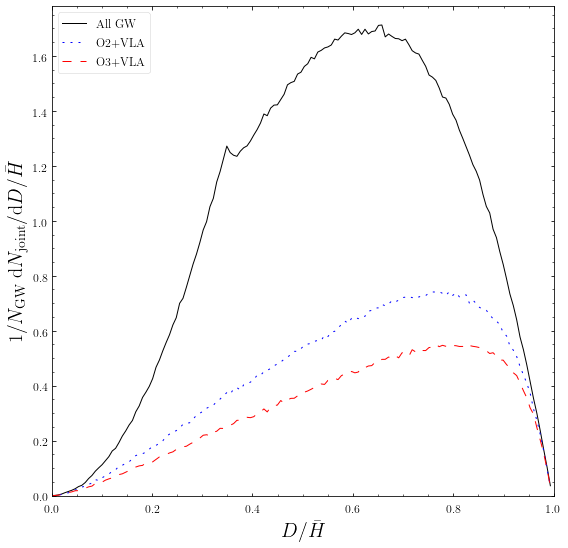

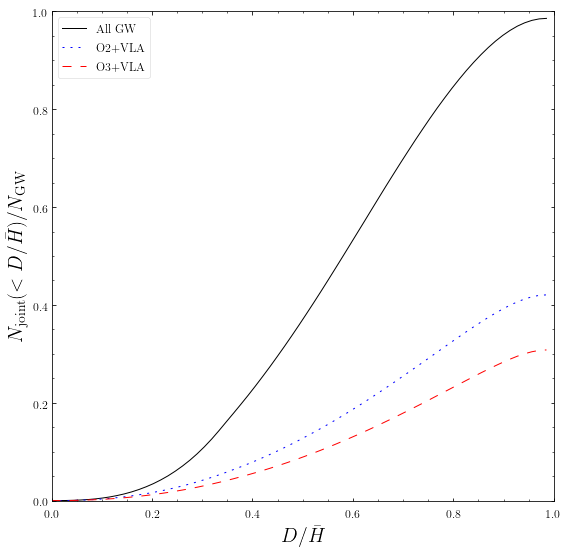

In [379]:
BINSD = 150
BINS2 = BINSD
BINS3 = BINSD
dash=[9, 9]
dot=[2, 6, 2, 6, 2, 6]
dashdot=[12, 6, 12, 6, 3, 6]
thin=0.7
thick=1.0
print("fig3a")
plt.figure(figsize=(9., 9.))
xbins= np.linspace(0., 1., BINSD)
counts, bin_edges = np.histogram(gw_design['d'] / AH_DESIGN, bins=xbins, density=True)
plt.plot(xbins[:-1], counts , label="All GW",
linewidth=thick, color="black", linestyle="-")
xbins= np.linspace(0., 1., BINS2)
counts2, bin_edges2 = np.histogram(gw_vla_O2['d'] / AH_O2, bins=xbins, density=True)
plt.plot(xbins[:-1], counts2 * f_vla_O2, label="O2+VLA",
linewidth=thick, color="blue", dashes=dot)
xbins= np.linspace(0., 1., BINS3)
counts3, bin_edges3 = np.histogram(gw_vla_O3['d'] / AH_O3, bins=xbins, density=True)
plt.plot(xbins[:-1], counts3 * f_vla_O3, label="O3+VLA",
linewidth=thick, color="red", dashes=dash)
plt.xlabel(r"$D/\bar{H}$")
plt.ylabel(r"$1/N_{\rm GW}~{\rm d}N_{\rm joint}/{\rm d}D/\bar{H}$")
plt.legend(loc="upper left")
plt.xlim([0,1])
plt.ylim([0,1.78])
plt.savefig(f"{PLOT_DIR}/fig3a.pdf", bbox_inches='tight')
plt.close("All")

print("fig3b")
BINS=70
plt.figure(figsize=(9., 9.))
xbins= np.linspace(0., 1., BINS)
counts, bin_edges = np.histogram(gw_O3['d'] / AH_O3, bins=xbins, density=True)
plt.plot(xbins[:-1], np.cumsum(counts) / BINS , label="All GW",
linewidth=thick, color="black", linestyle="-")
counts2, bin_edges2 = np.histogram(gw_vla_O2['d'] / AH_O2, bins=xbins, density=True)
plt.plot(xbins[:-1], np.cumsum(counts2) * f_vla_O2 / BINS, label="O2+VLA",
linewidth=thick, color="blue", dashes=dot)
counts3, bin_edges3 = np.histogram(gw_vla_O3['d'] / AH_O3, bins=xbins, density=True)
plt.plot(xbins[:-1], np.cumsum(counts3) * f_vla_O3 / BINS, label="O3+VLA",
linewidth=thick, color="red", dashes=dash)
plt.xlabel(r"$D/\bar{H}$")
plt.ylabel(r"$N_{\rm joint}(< D/\bar{H})/N_{\rm GW}$")
plt.legend(loc="upper left")
plt.xlim([0,1])
plt.ylim([0,1])
plt.savefig(f"{PLOT_DIR}/fig3b.pdf", bbox_inches='tight')
plt.close("All")


fig4a
fig4b


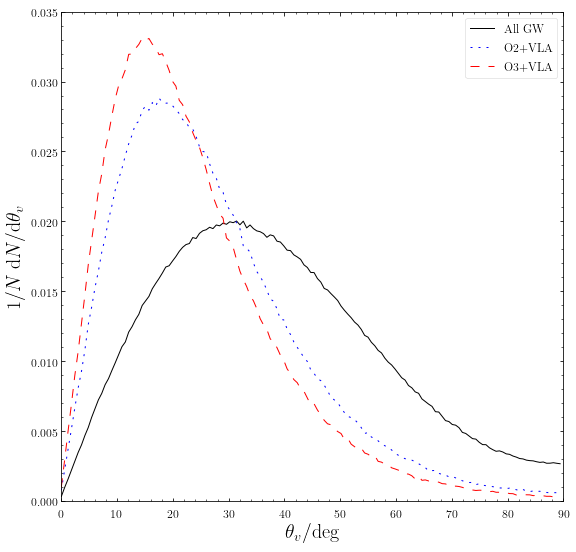

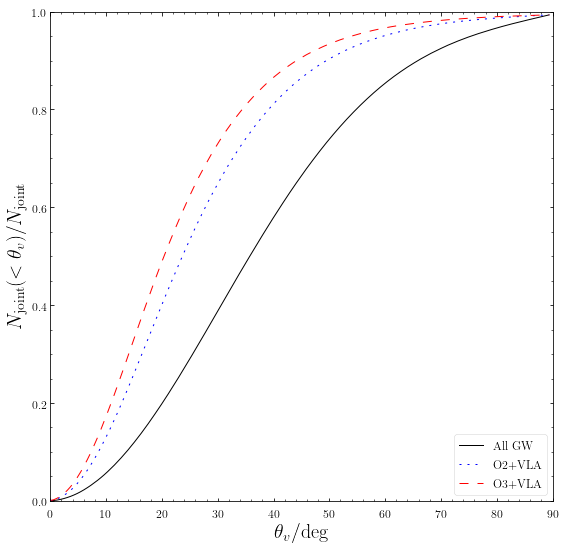

In [380]:
print("fig4a")
plt.figure(figsize=(9., 9.))
xbins= np.linspace(0., 90., BINSD)
counts, bin_edges = np.histogram(gw_design['tv'] * 180 / Pi, bins=xbins, density=True)
plt.plot(xbins[:-1], counts , label="All GW",
linewidth=thick, color="black", linestyle="-")
xbins= np.linspace(0., 90., BINS2)
counts2, bin_edges2 = np.histogram(gw_vla_O2['tv'] * 180 / Pi, bins=xbins, density=True)
plt.plot(xbins[:-1], counts2, label="O2+VLA",
linewidth=thick, color="blue", dashes=dot)
xbins= np.linspace(0., 90., BINS3)
counts3, bin_edges3 = np.histogram(gw_vla_O3['tv'] * 180 / Pi, bins=xbins, density=True)
plt.plot(xbins[:-1], counts3, label="O3+VLA",
linewidth=thick, color="red", dashes=dash)
plt.xlabel(r"$\theta_v / {\rm deg}$")
plt.ylabel(r"$1/N~{\rm d}N/{\rm d}\theta_v$")
plt.legend(loc="upper right")
plt.xlim([0,90])
plt.ylim([0,0.035])
plt.savefig(f"{PLOT_DIR}/fig4a.pdf", bbox_inches='tight')
plt.close("All")

print("fig4b")
plt.figure(figsize=(9., 9.))
xbins= np.linspace(0., 90., BINSD)
counts, bin_edges = np.histogram(gw_design['tv'] * 180 / Pi, bins=xbins, density=True)
plt.plot(xbins[:-1], np.cumsum(counts) * 90. / BINSD, label="All GW",
linewidth=thick, color="black", linestyle="-")
xbins= np.linspace(0., 90., BINS2)
counts2, bin_edges2 = np.histogram(gw_vla_O2['tv'] * 180 / Pi, bins=xbins, density=True)
plt.plot(xbins[:-1], np.cumsum(counts2)  * 90. / BINS2, label="O2+VLA",
linewidth=thick, color="blue", dashes=dot)
xbins= np.linspace(0., 90., BINS3)
counts3, bin_edges3 = np.histogram(gw_vla_O3['tv'] * 180 / Pi, bins=xbins, density=True)
plt.plot(xbins[:-1], np.cumsum(counts3) * 90. / BINS3, label="O3+VLA",
linewidth=thick, color="red", dashes=dash)
plt.xlabel(r"$\theta_v / {\rm deg}$")
plt.ylabel(r"$N_{\rm joint}(< \theta_v)/N_{\rm joint}$")
plt.legend(loc="lower right")
plt.xlim([0,90])
plt.ylim([0,1])
plt.savefig(f"{PLOT_DIR}/fig4b.pdf", bbox_inches='tight')
plt.close("All")


fig6a
4337.920999999999
[ 0.          3.3557047   6.7114094  10.06711409 13.42281879 16.77852349
 20.13422819 23.48993289 26.84563758 30.20134228] [0.01799815 0.01574972 0.01393525 0.01249356 0.01145624 0.01060178
 0.0098569  0.00915202 0.00855201 0.0079678 ] [0.01799815 0.03374787 0.04768312 0.06017668 0.07163292 0.08223469
 0.09209159 0.1012436  0.10979561 0.11776342]
[486.57718121 489.93288591 493.2885906  496.6442953  500.        ] [0.00012672 0.00012034 0.00012403 0.00011126 0.0001163 ] [0.29752806 0.2976484  0.29777243 0.2978837  0.298     ]
fig6b
fig6c


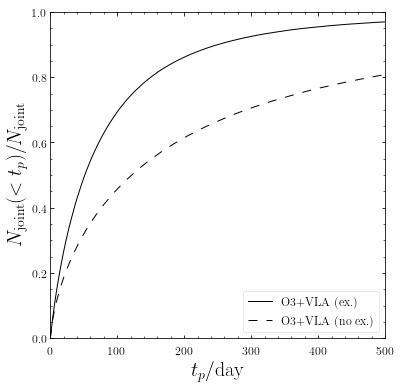

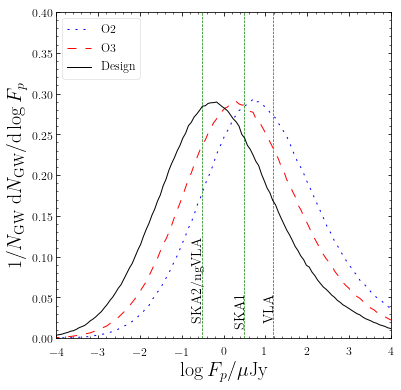

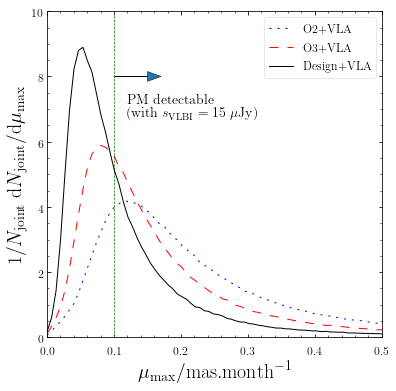

In [381]:
print("fig6a")
plt.figure(figsize=(6., 6.))
xbins=np.linspace(0, 500, BINSD)
a = float(len(gw_vla_O3.loc[gw_vla_O3['pte'] < 500.]))/len(gw_vla_O3)
b = float(len(gw_vla_O3.loc[gw_vla_O3['ptne'] < 500.]))/len(gw_vla_O3)
counts2, bin_edges2 = np.histogram(gw_vla_O3['pte'], bins=xbins, density=True)
plt.plot(xbins, np.insert(np.cumsum(counts2) * a * 500 / BINSD, 0, 0), label="O3+VLA (ex.)",
linewidth=thick, color="black", linestyle="-")
counts3, bin_edges3 = np.histogram(gw_vla_O3['ptne'], bins=xbins, density=True)
plt.plot(xbins, np.insert(np.cumsum(counts3) * b * 500 / BINSD, 0, 0), label="O3+VLA (no ex.)",
linewidth=thick, color="black", dashes=dash)
#plt.hist(gw_vla_O3['pte'], bins=np.append(np.linspace(0, 500, BINSD), 6000), density=True, cumulative=True, linewidth=thick, color="black", linestyle="-",
#       label="O3+VLA (ex.)", histtype="step")
#plt.hist(gw_vla_O3['ptne'], bins=np.append(np.linspace(0, 500, BINSD), 6000), density=True, cumulative=True, linewidth=thick, color="black", dashes=dash,
#       label="O3+VLA (no ex.)", histtype="step")
plt.xlabel(r"$t_p / {\rm day}$")
plt.ylabel(r"$N_{\rm joint}(< t_p)/N_{\rm joint}$")
plt.legend(loc="lower right")
plt.xlim([0., 500.])
plt.ylim([0,1])
plt.savefig(f"{PLOT_DIR}/fig6a.pdf", bbox_inches='tight')
plt.close("All")
print(max(gw_vla_O3['pte']))
print(xbins[:10], counts2[:10], np.cumsum(counts2)[:10])
print(xbins[-5:], counts2[-5:], np.cumsum(counts2)[-5:])

print("fig6b")
plt.figure(figsize=(6., 6.))
xbins= np.linspace(-5, 5, BINS2)
counts, bin_edges = np.histogram(gw_O2['lpf'], bins=xbins, density=True)
plt.plot(xbins[:-1], counts , label="O2",
linewidth=thick, color="blue", dashes=dot)
xbins= np.linspace(-5, 5, BINS3)
counts2, bin_edges2 = np.histogram(gw_O3['lpf'], bins=xbins, density=True)
plt.plot(xbins[:-1], counts2, label="O3",
linewidth=thick, color="red", dashes=dash)
xbins= np.linspace(-5, 5, BINSD)
counts3, bin_edges3 = np.histogram(gw_design['lpf'], bins=xbins, density=True)
plt.plot(xbins[:-1], counts3, label="Design",
linewidth=thick, color="black", linestyle="-")
plt.vlines(log(vlas), 0, 1, linestyles='dashed', linewidth=thin, color="green")
plt.vlines(log(ska1s), 0, 1, linestyles='dashed',linewidth=thin, color="green")
plt.vlines(log(ska2s), 0, 1, linestyles='dashed', linewidth=thin, color="green")
plt.xlabel(r"$\log F_p / {\rm \mu Jy}$")
plt.ylabel(r"$1/N_{\rm GW}~{\rm d}N_{\rm GW}/{\rm d}\log F_p$")
plt.legend(loc="upper left")
plt.xlim([-4., 4.])
plt.ylim([0, 0.4])
plt.text(log(vlas)-0.25, 0.04, "VLA", rotation=90, fontsize=14)
plt.text(log(ska1s)-0.25, 0.04, "SKA1", rotation=90, fontsize=14)
plt.text(log(ska2s)-0.25, 0.11, "SKA2/ngVLA", rotation=90, fontsize=14)
plt.savefig(f"{PLOT_DIR}/fig6b.pdf", bbox_inches='tight')
plt.close("All")

print("fig6c")
plt.figure(figsize=(6., 6.))
xbins= np.linspace(0., 1, BINS2)
counts, bin_edges = np.histogram([a for a in gw_vla_O2['pm'] if a > 0], bins=xbins, density=True)
plt.plot(xbins[:-1], counts[:] , label=r"O2+VLA",
linewidth=thick, color="blue", dashes=dot)
xbins= np.linspace(0., 1, BINS3)
counts2, bin_edges2 = np.histogram([a for a in gw_vla_O3['pm'] if a > 0], bins=xbins, density=True)
plt.plot(xbins[:-1], counts2[:], label="O3+VLA",
linewidth=thick, color="red", dashes=dash)
xbins= np.linspace(0., 1, BINSD)
counts3, bin_edges3 = np.histogram([a for a in gw_vla_design['pm'] if a > 0], bins=xbins, density=True)
plt.plot(xbins[:-1], counts3[:], label="Design+VLA",
linewidth=thick, color="black", linestyle="-")
plt.xlabel(r"$\mu_{\rm max} / {\rm mas.month}^{-1}$")
plt.ylabel(r"$1/N_{\rm joint}~{\rm d}N_{\rm joint}/{\rm d}\mu_{\rm max}$")
plt.legend(loc="upper right")
plt.xlim([0., 0.5])
plt.ylim([0, 10])
plt.vlines(0.1, 0, 20, linestyles='dashed', linewidth=thin, color="green")
#plt.arrow(0.1, 4,0.05, 0, head_width=0.3, head_length=0.02)
plt.arrow(0.1, 8, 0.05, 0,  head_width=0.3, head_length=0.02)
plt.text(0.12, 7.2, "PM detectable", fontsize=14)
plt.text(0.12, 6.7, r"(with $s_{\rm VLBI}=15~\mu{\rm Jy}$)", fontsize=14)
plt.savefig(f"{PLOT_DIR}/fig6c.pdf", bbox_inches='tight')
plt.close("All")


In [382]:
min(gw_vla_O3['pte'])

3.280091e-05

fig8a
fig8b


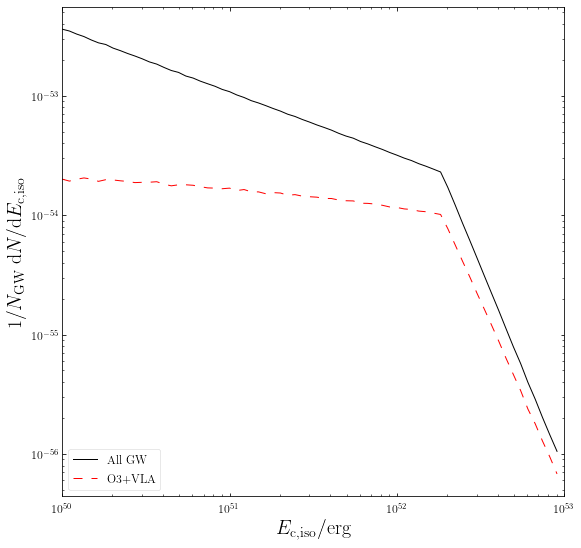

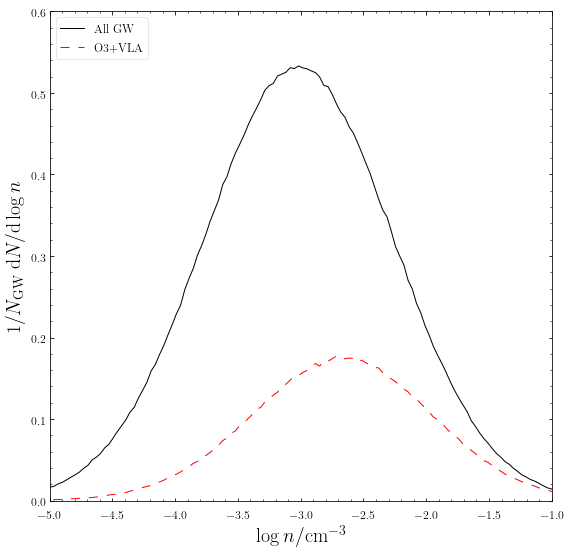

In [383]:
print(f"fig8a")
P = len(gw_vla_O3['ln'])
Q = len(gw_O3['ln'])
R = len(df['ln'])
plt.figure(figsize=(9., 9.))
xbins=10 ** np.linspace(50, 53, BINS)
counts, bin_edges = np.histogram(gw_O3['e0'], bins=xbins)
plt.plot(xbins[:-1], counts / (Q * bin_edges[:-1]), label="All GW",
linewidth=thick, color="black")
counts2, bin_edges2 = np.histogram(gw_vla_O3['e0'], bins=xbins)
plt.plot(xbins[:-1], counts2 / (Q * bin_edges2[:-1]), label="O3+VLA",
linewidth=thick, color="red", dashes=dash)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$E_{\rm c, iso}/{\rm erg}$")
plt.ylabel(r"$1/N_{\rm GW}~{\rm d}N/{\rm d}E_{\rm c,iso}$")
plt.legend(loc="lower left")
plt.xlim([bin_edges[0], bin_edges[-1]])
plt.savefig(f"{PLOT_DIR}/fig8a.pdf", bbox_inches='tight')
plt.close("All")

print("fig8b")
plt.figure(figsize=(9., 9.))
xbins= np.linspace(-5.5, -0.5, BINSD)
counts, bin_edges = np.histogram(gw_design['ln'], bins=xbins, density=True)
plt.plot(xbins[:-1], counts , label="All GW",
linewidth=thick, color="black", linestyle="-")
xbins= np.linspace(-5.5, -0.5, BINS3)
counts3, bin_edges3 = np.histogram(gw_vla_O3['ln'], bins=xbins, density=True)
plt.plot(xbins[:-1], counts3 * f_vla_O3, label="O3+VLA",
linewidth=thick, color="red", dashes=dash)
plt.xlabel(r"$\log n/{\rm cm}^{-3}$")
plt.ylabel(r"$1/N_{\rm GW}~{\rm d}N/{\rm d}\log n$")
plt.legend(loc="upper left")
plt.xlim([-5,-1])
plt.ylim([0,0.6])
plt.savefig(f"{PLOT_DIR}/fig8b.pdf", bbox_inches='tight')
plt.close("All")

fig5a
fig5b


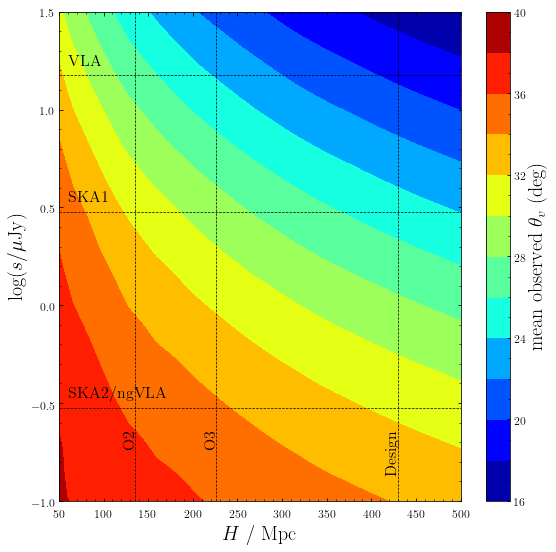

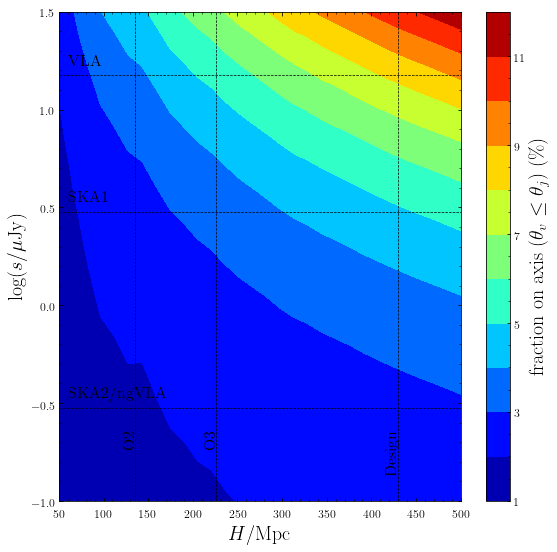

In [395]:
print("fig5a")
plt.figure(figsize=(9., 9.))
plt.xlabel("$H$ / Mpc")
plt.ylabel(r"$\log(s/\mu {\rm Jy})$")
plt.vlines(GWH_O2, LS_MIN, LS_MAX, linestyles='dashed', linewidth=thin)
plt.vlines(GWH_O3, LS_MIN, LS_MAX, linestyles='dashed', linewidth=thin)
plt.vlines(GWH_DESIGN, LS_MIN, LS_MAX, linestyles='dashed', linewidth=thin)
plt.hlines(log(vlas), GWH_MIN, GWH_MAX, linestyles='dashed', linewidth=thin)
plt.hlines(log(ska1s), GWH_MIN, GWH_MAX, linestyles='dashed', linewidth=thin)
plt.hlines(log(ska2s), GWH_MIN, GWH_MAX, linestyles='dashed', linewidth=thin)
plt.contourf(X, Y, mean_tv * 180 / Pi, cmap='jet', levels=11)
cbar = plt.colorbar()
cbar.set_label(r'mean observed $\theta_v$ (deg)')
plt.text(GWH_O2-15, -0.7, "O2", rotation=90, fontsize=16)
plt.text(GWH_O3-15, -0.7, "O3", rotation=90, fontsize=16)
plt.text(GWH_DESIGN-15, -0.7, "Design", rotation=90, fontsize=16)
plt.text(60, log(vlas)+0.051, "VLA", rotation=0, fontsize=16)
plt.text(60, log(ska1s)+0.051, "SKA1", rotation=0, fontsize=16)
plt.text(60, log(ska2s)+0.051, "SKA2/ngVLA", rotation=0, fontsize=16)
plt.savefig(f"{PLOT_DIR}/fig5a.pdf", bbox_inches = 'tight')

print("fig5b")
plt.figure(figsize=(9., 9.))
plt.xlabel("$H$/Mpc")
plt.ylabel(r"$\log(s/\mu {\rm Jy})$")
plt.vlines(GWH_O2, LS_MIN, LS_MAX, linestyles='dashed', linewidth=thin)
plt.vlines(GWH_O3, LS_MIN, LS_MAX, linestyles='dashed', linewidth=thin)
plt.vlines(GWH_DESIGN, LS_MIN, LS_MAX, linestyles='dashed', linewidth=thin)
plt.hlines(log(vlas), GWH_MIN, GWH_MAX, linestyles='dashed', linewidth=thin)
plt.hlines(log(ska1s), GWH_MIN, GWH_MAX, linestyles='dashed', linewidth=thin)
plt.hlines(log(ska2s), GWH_MIN, GWH_MAX, linestyles='dashed', linewidth=thin)
plt.contourf(X, Y, 100 * frac_onaxis, cmap='jet', levels=11)
cbar = plt.colorbar()
cbar.set_label(r'fraction on axis ($\theta_v \leq \theta_j$) (\%)')
plt.text(GWH_O2-15, -0.7, "O2", rotation=90, fontsize=16)
plt.text(GWH_O3-15, -0.7, "O3", rotation=90, fontsize=16)
plt.text(GWH_DESIGN-15, -0.7, "Design", rotation=90, fontsize=16)
plt.text(60, log(vlas)+0.051, "VLA", rotation=0, fontsize=16)
plt.text(60, log(ska1s)+0.051, "SKA1", rotation=0, fontsize=16)
plt.text(60, log(ska2s)+0.051, "SKA2/ngVLA", rotation=0, fontsize=16)
plt.savefig(f"{PLOT_DIR}/fig5b.pdf", bbox_inches = 'tight')


fig2a
2.7865679016203453
fig2b


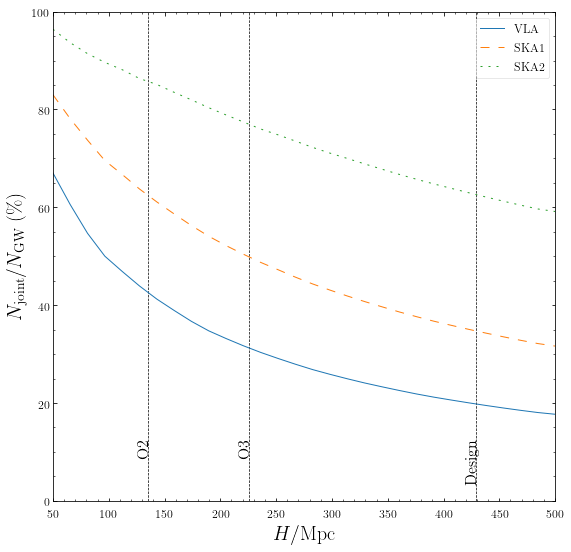

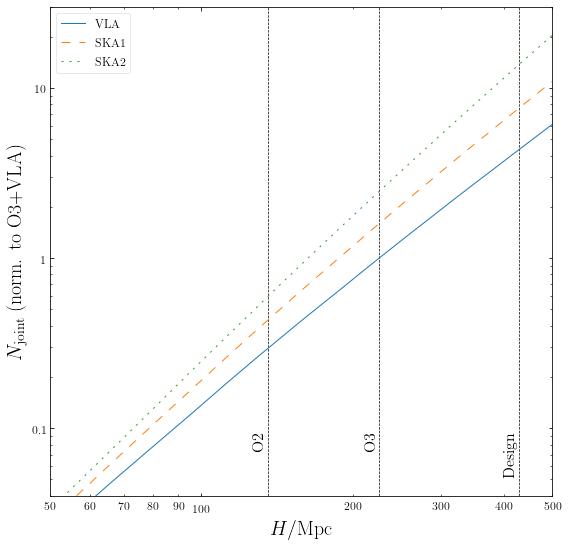

In [396]:

print("fig2a")
plt.figure(figsize=(9., 9.))
plt.plot(gwh_l, 100 * frac_vla / 0.29, label="VLA", linestyle="-", linewidth=thick)
plt.plot(gwh_l, 100 * frac_ska1 / 0.29, label="SKA1", dashes=dash, linewidth=thick)
plt.plot(gwh_l, 100 * frac_ska2 / 0.29, label="SKA2", dashes=dot, linewidth=thick)
plt.xlabel(r"$H/{\rm Mpc}$")
plt.ylabel(r"$N_{\rm joint} / N_{\rm GW}$ (\%)")
plt.xlim([50, 500])
plt.ylim([0, 100])
#plt.set_aspect("equal")
plt.vlines([GWH_O2, GWH_O3, GWH_DESIGN],
        0, 100, linestyles='dashed', linewidth=thin)
plt.text(GWH_O2-11, 10, "O2", rotation=90, fontsize=16)
plt.text(GWH_O3-11, 10, "O3", rotation=90, fontsize=16)
plt.text(GWH_DESIGN-11, 10, "Design", rotation=90, fontsize=16)
plt.legend()
plt.savefig(f"{PLOT_DIR}/fig2a.pdf", bbox_inches='tight')
plt.close("All")
print((log(num_ska2[-1]) - log(num_ska2[0])) / (log(gwh_l[-1]) - log(gwh_l[0])))

print("fig2b")
fig, ax = plt.subplots(figsize=(9., 9.))
ax.loglog()
import matplotlib.ticker as ticker
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:d}'.format(int(y))))
ax.xaxis.set_minor_formatter(ticker.FuncFormatter(lambda y, _: '{:d}'.format(int(y))))
ax.plot(gwh_l, num_vla, label="VLA", linestyle="-", linewidth=thick)
ax.plot(gwh_l, num_ska1, label="SKA1", dashes=dash, linewidth=thick)
ax.plot(gwh_l, num_ska2, label="SKA2", dashes=dot, linewidth=thick)

#plt.xlim([50, 500])
#plt.ylim([4.e-2, 30])
ax.axis([50, 500, 4.e-2, 30])
plt.vlines([GWH_O2, GWH_O3, GWH_DESIGN],
        0, 100, linestyles='dashed', linewidth=thin)
plt.text(GWH_O2/1.08, 8.e-2, "O2", rotation=90, fontsize=16)
plt.text(GWH_O3/1.08, 8.e-2, "O3", rotation=90, fontsize=16)
plt.text(GWH_DESIGN/1.08, 8.e-2, "Design", rotation=90, fontsize=16)
plt.xlabel(r"$H/{\rm Mpc}$")
plt.ylabel(r"$N_{\rm joint}$ (norm. to O3+VLA)")
plt.legend()
plt.savefig(f"{PLOT_DIR}/fig2b.pdf", bbox_inches='tight')
plt.close("All")


fig7a


/Users/duque/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


fig7b
fig7c
fig7d


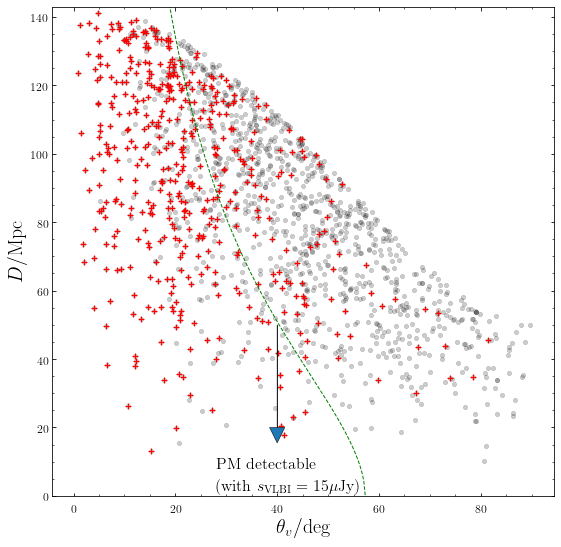

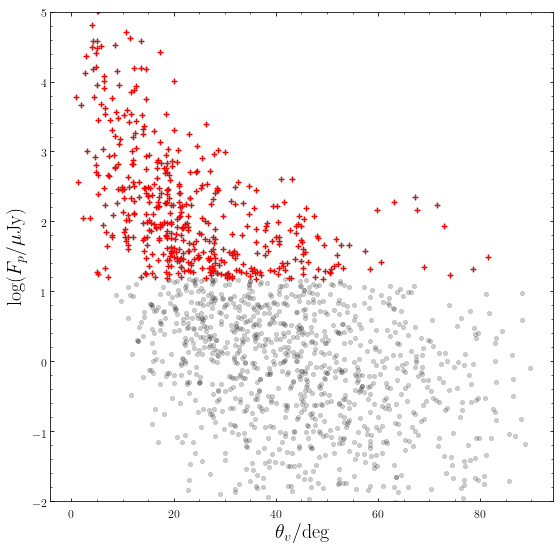

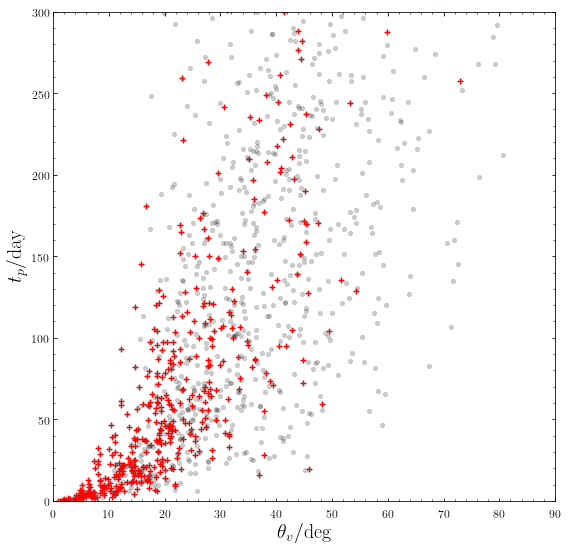

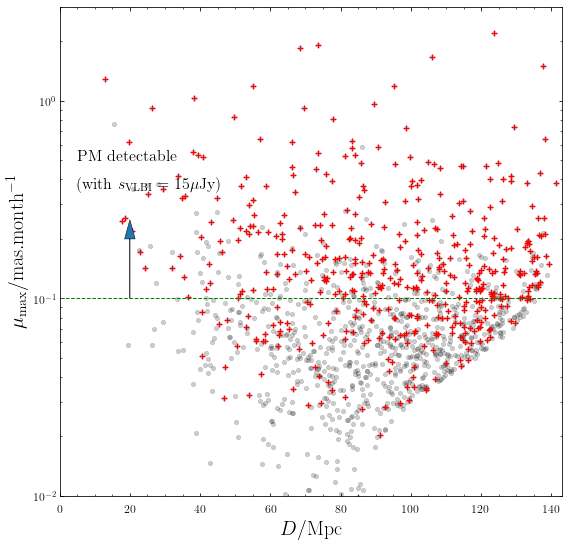

In [397]:
N = 1500
M = int(f_vla_O3 * N)
r = gw_O3
s = gw_vla_O3
al=0.2
print("fig7a")
plt.figure(figsize=(9., 9.))
f = lambda x: sqrt(1 - x ** 2) * sin(x)/(1 - sqrt(1 - x ** 2) * cos(x))
xl = np.linspace(0, 1, 200)
plt.plot(xl * 180 / Pi, 50 * f(xl), color="green", linewidth=thick, linestyle="dashed")
plt.scatter(r['tv'][4:4 + N] * 180 / Pi, r['d'][4:4 + N], color="black", alpha=al,
    marker=".", s=80)
plt.scatter(s['tv'][4:4 + M] * 180 / Pi, s['d'][4:4+M], color="red",
    marker="+")
plt.xlabel(r"$\theta_v / {\rm deg}$")
plt.ylabel(r"$D / {\rm Mpc}$")
plt.ylim([0, 143])
plt.arrow(40, 50, 0.0, -30,  head_width=3)#, head_length=0.02)
plt.text(28, 8, "PM detectable", fontsize=16)
plt.text(28, 1, r"(with $s_{\rm VLBI}=15\mu{\rm Jy}$)", fontsize=16)
plt.savefig(f"{PLOT_DIR}/fig7a.pdf", bbox_inches='tight')

print("fig7b")
plt.figure(figsize=(9., 9.))
plt.scatter(r['tv'][4:4 + N] * 180 / Pi, r['lpf'][4:4 + N], color="black", alpha=al,
    marker=".", s=80)
plt.scatter(s['tv'][4:4+M] * 180 / Pi, s['lpf'][4:4+M], color="red",
    marker="+")
plt.xlabel(r"$\theta_v / {\rm deg}$")
plt.ylabel(r"$\log(F_p / \mu{\rm Jy})$")
plt.ylim([-2, 5])
plt.savefig(f"{PLOT_DIR}/fig7b.pdf", bbox_inches='tight')

print("fig7c")
plt.figure(figsize=(9., 9.))
plt.scatter(r['tv'][4:4 + N] * 180 / Pi, r['pte'][4:4 + N], color="black", alpha=al,
    marker=".", s=80)
plt.scatter(s['tv'][4:4+M] * 180 / Pi, s['pte'][4:4+M], color="red",
    marker="+")
plt.xlabel(r"$\theta_v / {\rm deg}$")
plt.ylabel(r"$t_p / {\rm day}$")
plt.ylim([0, 300])
plt.xlim([0, 90])
plt.savefig(f"{PLOT_DIR}/fig7c.pdf", bbox_inches='tight')

print("fig7d")
plt.figure(figsize=(9., 9.))
plt.scatter(r['d'][4:4 + N], 1.e-6 + r['pm'][4:4 + N], color="black", alpha=al,
    marker=".", s=80)
plt.scatter(s['d'][4:4+M], 1.e-6 + s['pm'][4:4+M], color="red",
    marker="+")
plt.hlines(0.1, 0, 143, linestyle="dashed", color="green", linewidth=thick)
plt.yscale('log')
plt.ylim([0.01, 3])
plt.xlim([0, 143])
plt.ylabel(r"$\mu_{\rm max} / {\rm mas.month}^{-1}$")
plt.xlabel(r"$D / {\rm Mpc}$")
plt.arrow(20, 0.1, 0.0, 0.4/4,  head_width=3, head_length=0.2/4)#, head_length=0.02)
plt.text(5, 1./2, "PM detectable", fontsize=16)
plt.text(5, 0.7/2, r"(with $s_{\rm VLBI}=15\mu{\rm Jy}$)", fontsize=16)
plt.savefig(f"{PLOT_DIR}/fig7d.pdf", bbox_inches='tight')


fig9a
fig9b
fig9c


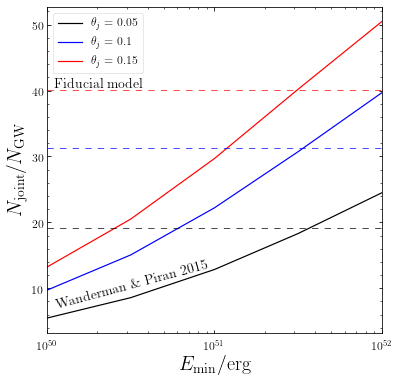

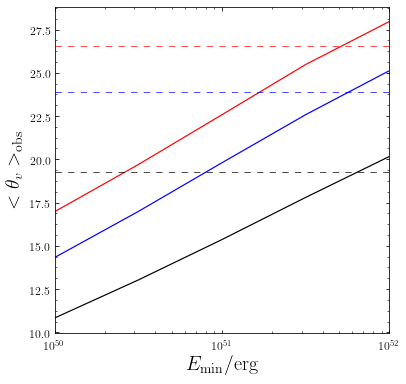

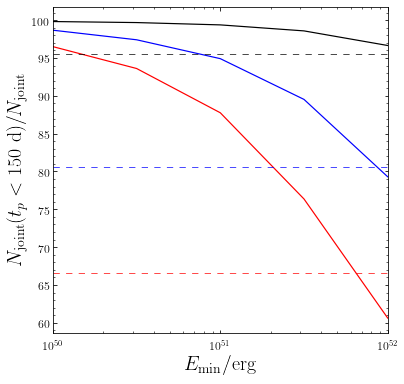

In [411]:
print("fig9a")
plt.figure(figsize=(6., 6.))
plt.plot(e0l, wpfrac["005"], linestyle="-", color="black", label=r"$\theta_j = 0.05$")
plt.plot(e0l, wpfrac["010"], linestyle="-", color="blue", label=r"$\theta_j = 0.1$")
plt.plot(e0l, wpfrac["015"], linestyle="-", color="red", label=r"$\theta_j = 0.15$")
plt.plot([10**50, 10**52], [g16frac["005"], g16frac["005"]], dashes=dash, color="black", linewidth=thin)
plt.plot([10**50, 10**52], [g16frac["010"], g16frac["010"]], dashes=dash, color="blue", linewidth=thin)
plt.plot([10**50, 10**52], [g16frac["015"], g16frac["015"]], dashes=dash, color="red", linewidth=thin)
plt.xscale('log')
plt.text(1.1e50, 40.5, "Fiducial model", fontsize=14)
plt.text(1.1e50, 13, "Wanderman \& Piran 2015", fontsize=14, rotation=15)
plt.legend(loc='upper left')
plt.xlabel(r"$E_{\rm min} / {\rm erg}$")
plt.ylabel(r"$N_{\rm joint} / N_{\rm GW}$")
plt.xlim([min(e0l), max(e0l)])
plt.savefig(f"{PLOT_DIR}/fig9a.pdf", bbox_inches='tight')

print("fig9b")
plt.figure(figsize=(6., 6.))
plt.plot(e0l, wpang["005"], linestyle="-", color="black", label=r"$\theta_j = 0.05$")
plt.plot(e0l, wpang["010"], linestyle="-", color="blue", label=r"$\theta_j = 0.1$")
plt.plot(e0l, wpang["015"], linestyle="-", color="red", label=r"$\theta_j = 0.15$")
plt.plot([10**50, 10**52], [g16ang["005"], g16ang["005"]], dashes=dash, color="black", linewidth=thin)
plt.plot([10**50, 10**52], [g16ang["010"], g16ang["010"]], dashes=dash, color="blue", linewidth=thin)
plt.plot([10**50, 10**52], [g16ang["015"], g16ang["015"]], dashes=dash, color="red", linewidth=thin)
plt.xscale('log')
plt.xlabel(r"$E_{\rm min} / {\rm erg}$")
plt.ylabel(r"$<\theta_v>_{\rm obs}$")
plt.xlim([min(e0l),max(e0l)])
plt.savefig(f"{PLOT_DIR}/fig9b.pdf", bbox_inches='tight')

print("fig9c")
plt.figure(figsize=(6., 6.))
plt.plot(e0l, wpf150["005"], linestyle="-", color="black", label=r"$\theta_j = 0.05$")
plt.plot(e0l, wpf150["010"], linestyle="-", color="blue", label=r"$\theta_j = 0.1$")
plt.plot(e0l, wpf150["015"], linestyle="-", color="red", label=r"$\theta_j = 0.15$")
plt.plot([10**50, 10**52], [g16f150["005"], g16f150["005"]], dashes=dash, color="black", linewidth=thin)
plt.plot([10**50, 10**52], [g16f150["010"], g16f150["010"]], dashes=dash, color="blue", linewidth=thin)
plt.plot([10**50, 10**52], [g16f150["015"], g16f150["015"]], dashes=dash, color="red", linewidth=thin)
plt.xscale('log')
plt.xlabel(r"$E_{\rm min} / {\rm erg}$")
plt.ylabel(r"$N_{\rm joint}(t_p < 150~{\rm d}) / N_{\rm joint}$")
plt.xlim([min(e0l), max(e0l)])
plt.savefig(f"{PLOT_DIR}/fig9c.pdf", bbox_inches='tight')


In [388]:
float(len(gw_vla_O3.loc[gw_vla_O3['tv'] * 180 / Pi < 20]))/len(gw_vla_O3)

0.474278867860533

In [389]:
float(len(gw_vla_design.loc[(gw_vla_design['pf'] > 15.) & (gw_vla_design['pm'] > 0.1)]))/len(gw_vla_design)

0.42303722070521604

In [390]:
gw_vla_O3['ln'].mean()

-2.6600417519795436

In [391]:
10**(3-2.66)

2.1877616239495516

In [392]:
l = gw_vla_O3['ln']
l

23        -2.752326
31        -2.622209
38        -2.733638
48        -2.330587
63        -2.904291
75        -2.982794
78        -3.226709
86        -3.022589
87        -3.228384
100       -2.676127
101       -2.728337
105       -3.123994
116       -2.933873
120       -4.147902
122       -2.503287
134       -2.455435
137       -1.904175
143       -1.895278
150       -2.133122
159       -1.908417
177       -4.427785
195       -2.245484
201       -2.401253
202       -3.395332
204       -2.381698
211       -2.070069
219       -1.531196
223       -1.969268
225       -3.508834
241       -2.928716
             ...   
9999644   -2.551546
9999673   -4.065098
9999678   -3.003159
9999688   -3.154753
9999698   -2.940704
9999719   -3.203152
9999722   -1.973069
9999734   -1.886497
9999737   -2.759073
9999742   -2.886504
9999783   -3.324091
9999790   -2.086370
9999804   -3.209576
9999807   -3.710785
9999820   -3.172807
9999821   -2.094835
9999825   -2.803455
9999831   -2.970892
9999857   -2.150647


In [393]:
np.kurtosis(l)

AttributeError: module 'numpy' has no attribute 'kurtosis'

In [ ]:
from scipy.stats import kurtosis, skew

In [ ]:
print(kurtosis(l))
print(skew(l))

In [ ]:
print(kurtosis(gw_O3['ln']))
print(skew(gw_O3['ln']))